# How many molecules do we need to add before we've seen all the bits?

I did an updated post last year looking at [the average number of bits set per molecule](https://greglandrum.github.io/rdkit-blog/fingerprints/reference/2021/07/06/number-of-fp-bits-set.html) by the various fingerprinting algorithms in the RDKit.

This one explores a couple of related topics: 
1. If we look at a large set of organic molecules, how many different atom environments (as defined by the individual fingerprints) do we observe?
2. How quickly does this number converge with the number of compounds considered?

Obviously the answer to these questions is extremely dependent on the set of molecules you use. For this post I will use a set of around six million random molecules from Zinc20's ["in-stock" set](https://zinc20.docking.org/substances/subsets/in-stock/). The six million included all have less than 50 heavy atoms after being salt stripped.

The experiment itself could hardly be simpler: read in the molecules, generate fingerprints, and keep track of the unique bits set as a function of number of molecules considered. For this analysis I limit myself to fingerprints which have not been "folded" to fit into a particular bit length (with the exception of the Avalon FP, which currently only supports generating folded forms).

The code and raw data are below, here are the curves showing the saturation behavior for the various fingerprints:
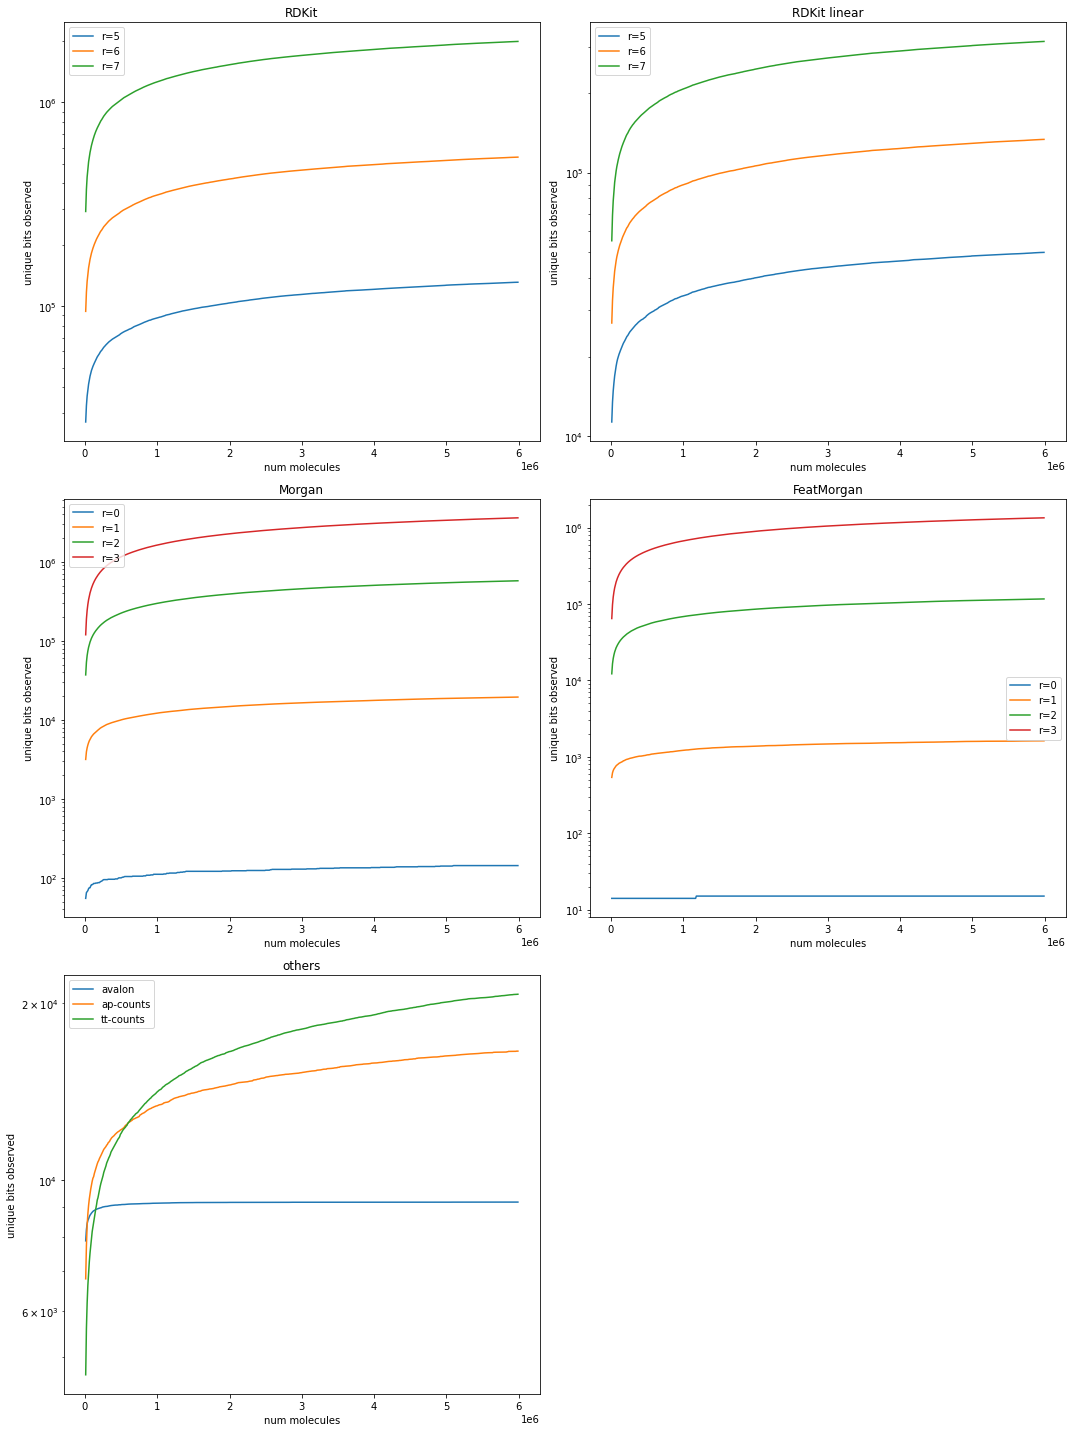

Note that the saturation behavior of the avalon fingerprint here is an artifact of the fact that the fingerprint being used was only 9192 bits long (yes, I made a typo when I entered the value in the script to generate the data); 9185 of those bits end up being set.

For a bit more resolution, here's a table with the number of unique bits set per fingerprint in that set of 6 million, the number of new bits found in the last 100K of the 5 million, as well as how many molecules needed to be considered to reach 90, 95, and 99% of the number of unique bits:

|                 | # unique bits | # in last 100K |    0.90 |    0.95 |    0.99 |
| --------------- | ------------- | -------------- | ------- | ------- | ------- |
| FeatMorgan0     |            15 |              0 | N/A     | N/A     | N/A     |
| FeatMorgan1     |          1621 |              2 | 2760000 | 4080000 | 5460000 |
| FeatMorgan2     |        116975 |            464 | 4000000 | 4870000 | 5750000 |
| FeatMorgan3     |       1350464 |           7478 | 4400000 | 5130000 | 5810000 |
| Morgan0         |           143 |              0 | 2850000 | 4080000 | 5080000 |
| Morgan1         |         19428 |             67 | 3870000 | 4750000 | 5720000 |
| Morgan2         |        575817 |           2941 | 4320000 | 5080000 | 5790000 |
| Morgan3         |       3606676 |          22970 | 4580000 | 5240000 | 5830000 |
| RDKit5          |        131029 |            347 | 3490000 | 4600000 | 5690000 |
| RDKit6          |        538500 |           1627 | 3600000 | 4680000 | 5700000 |
| RDKit7          |       1989958 |           6897 | 3740000 | 4760000 | 5720000 |
| RDKit-linear5   |         49852 |            136 | 3400000 | 4520000 | 5680000 |
| RDKit-linear6   |        133904 |            402 | 3480000 | 4570000 | 5690000 |
| RDKit-linear7   |        315293 |           1032 | 3570000 | 4640000 | 5700000 |
| ap-counts       |         16585 |             18 | 2470000 | 3840000 | 5410000 |
| avalon          |          9185 |              0 |   20000 |   70000 |  490000 |
| tt-counts       |         20723 |             49 | 3530000 | 4570000 | 5640000 |

To help with the interpretation of this: a total of 131029 unique bits were found for the RDKit5 fingerprint in the set of 6 million molecules and 95% of those bits had been found after looking at 4.6 million molecules. The last 100K molecules added 347 new bits.

The thing that I find most interesting (and somewhat surprising) about these results is how far we are from having encountered "all" of the bits; new bits are being encountered for almost all of the fingerprint types even after 5.9 million molecules have been encountered.  I can probably still wave my hands and estimate the order-of-magnitude number of distinct bits for each of the FP types in the full set of ~14 million substances in the ZINC20 "in-stock" set. Here's a few of those estimates:
- FeatMorgan2: 120-150K
- FeatMorgan3: 1.4-1.6 million
- Morgan1: 20-25K
- Morgan2: 600-700K
- Morgan3: 3.6-4.0 million

These are also rough lower bounds on the number of atom environments in those compounds (it's a lower bound due to the possibility of hash collisions causing multiple atom environments to hash to the same fingerprint bit).

In [1]:
from rdkit import Chem,DataStructs
import time,random,gzip,pickle,copy
import numpy as np
from collections import Counter,defaultdict
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit import rdBase
from rdkit import RDLogger
%pylab inline

print(rdBase.rdkitVersion)
import time
print(time.asctime())

Populating the interactive namespace from numpy and matplotlib
2021.09.3
Tue Jan  4 13:17:00 2022


/home/glandrum/miniconda3/envs/rdkit_blog/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
try:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.execute('from rdkit import Chem')
    dview.execute('from rdkit import Descriptors')
    dview.execute('from rdkit.Chem import rdMolDescriptors')
    dview.execute('from rdkit.Avalon import pyAvalonTools')
except:
    print("could not use ipyparallel")
    dview = None

Here's my local copy of the ~14 million "in stock" compounds I grabbed from ZINC (this file is too big for github):

In [3]:
filen='/scratch/RDKit_git/LocalData/Zinc20/purchasable/zinc20_instock.pkl.shuffled.gz'

Loop over the molecules, strip salts, skip anything with more than 50 atoms, and build fingerprints for all the others.

The fingerprints I generate for this analysis are:
- Sparse Morgan with radii 1, 2, and 3
- Sparse FeatureMorgan with radii 1, 2, and 3
- Sparse RDKit with maxPath 5, 6, and 7
- Sparse RDKit, no branches, with maxPath 5, 6, and 7
- Avalon BitVect
- Sparse Atom Pairs
- Sparse Topological Torsions

All of the BitVect fingerprints are 4096 bits long

In [ ]:
import copy
from collections import defaultdict
historyf = gzip.open('../data/fp_bit_counts.history.pkl.gz','wb+')
RDLogger.DisableLog('rdApp.info')
frm = rdMolStandardize.LargestFragmentChooser()
counts=defaultdict(list)
accum=defaultdict(set)
t1 = time.time()
with gzip.open(filen,'rb') as inf:
    i = 0
    ms = []
    while 1:
        try:
            m,nm = pickle.load(inf)
        except EOFError:
            break
        if not m:
            continue
        # strip salts:
        m = frm.choose(m)
        if m.GetNumHeavyAtoms()>50: 
            continue
        ms.append(m)
        i+=1
        if len(ms)>=10000:
            for v in 0,1,2,3:
                k = ('Morgan',v)
                cnts = dview.map_sync(lambda x,v=v:set(rdMolDescriptors.GetMorganFingerprint(x,v).GetNonzeroElements().keys()),
                                     ms)
                for obc in cnts:
                    accum[k].update(obc)
                counts[k].append((i,len(accum[k])))
            for v in 0,1,2,3:
                k = ('FeatMorgan',v)
                cnts = dview.map_sync(lambda x,v=v:set(rdMolDescriptors.GetMorganFingerprint(x,v,useFeatures=True).GetNonzeroElements().keys()),
                                     ms)
                for obc in cnts:
                    accum[k].update(obc)
                counts[k].append((i,len(accum[k])))
            for v in 5,6,7:
                k = ('RDKit',v)
                cnts = dview.map_sync(lambda x,v=v:set(Chem.UnfoldedRDKFingerprintCountBased(x,maxPath=v).GetNonzeroElements().keys()),
                                      ms)
                for obc in cnts:
                    accum[k].update(obc)
                counts[k].append((i,len(accum[k])))
            for v in 5,6,7:
                k = ('RDKit-linear',v)
                cnts = dview.map_sync(lambda x,v=v:set(Chem.UnfoldedRDKFingerprintCountBased(x,maxPath=v,branchedPaths=False).GetNonzeroElements().keys()),
                                      ms)
                for obc in cnts:
                    accum[k].update(obc)
                counts[k].append((i,len(accum[k])))

            k = ('avalon',-1)
            cnts = dview.map_sync(lambda x:set(pyAvalonTools.GetAvalonFP(x,nBits=9192).GetOnBits()),
                                  ms)
            for obc in cnts:
                accum[k].update(obc)
            counts[k].append((i,len(accum[k])))
            
            k = ('ap-counts',-1)
            cnts = dview.map_sync(lambda x:set(rdMolDescriptors.GetAtomPairFingerprint(x).GetNonzeroElements().keys()),
                                  ms)
            for obc in cnts:
                accum[k].update(obc)
            counts[k].append((i,len(accum[k])))
            k = ('tt-counts',-1)
            cnts = dview.map_sync(lambda x:set(rdMolDescriptors.GetTopologicalTorsionFingerprint(x).GetNonzeroElements().keys()),
                                  ms)
            for obc in cnts:
                accum[k].update(obc)
            counts[k].append((i,len(accum[k])))
            ms = []
            
        if not i%50000:
            t2 = time.time()
            print("Done %d in %.2f sec"%(i,t2-t1))
        if not i%500000:
            pickle.dump(dict(counts),historyf)
            pickle.dump(dict(accum),historyf)
        if i>=5500000:
            break

In [7]:
with gzip.open('../data/fp_bit_counts.history.pkl.gz','wb+') as outf:
    pickle.dump(dict(counts),outf)
    pickle.dump(dict(accum),outf)
        

In [14]:
with gzip.open('../data/fp_bit_counts.history.pkl.gz','rb') as inf:
    counts = pickle.load(inf)

Now plot the distributions of the number of bits set

We have a few extra data points, let's stick to the first 6 million molecules

In [21]:
for k,v in counts.items():
    v = [x for x in v if x[0]<6000000]
    counts[k] = v

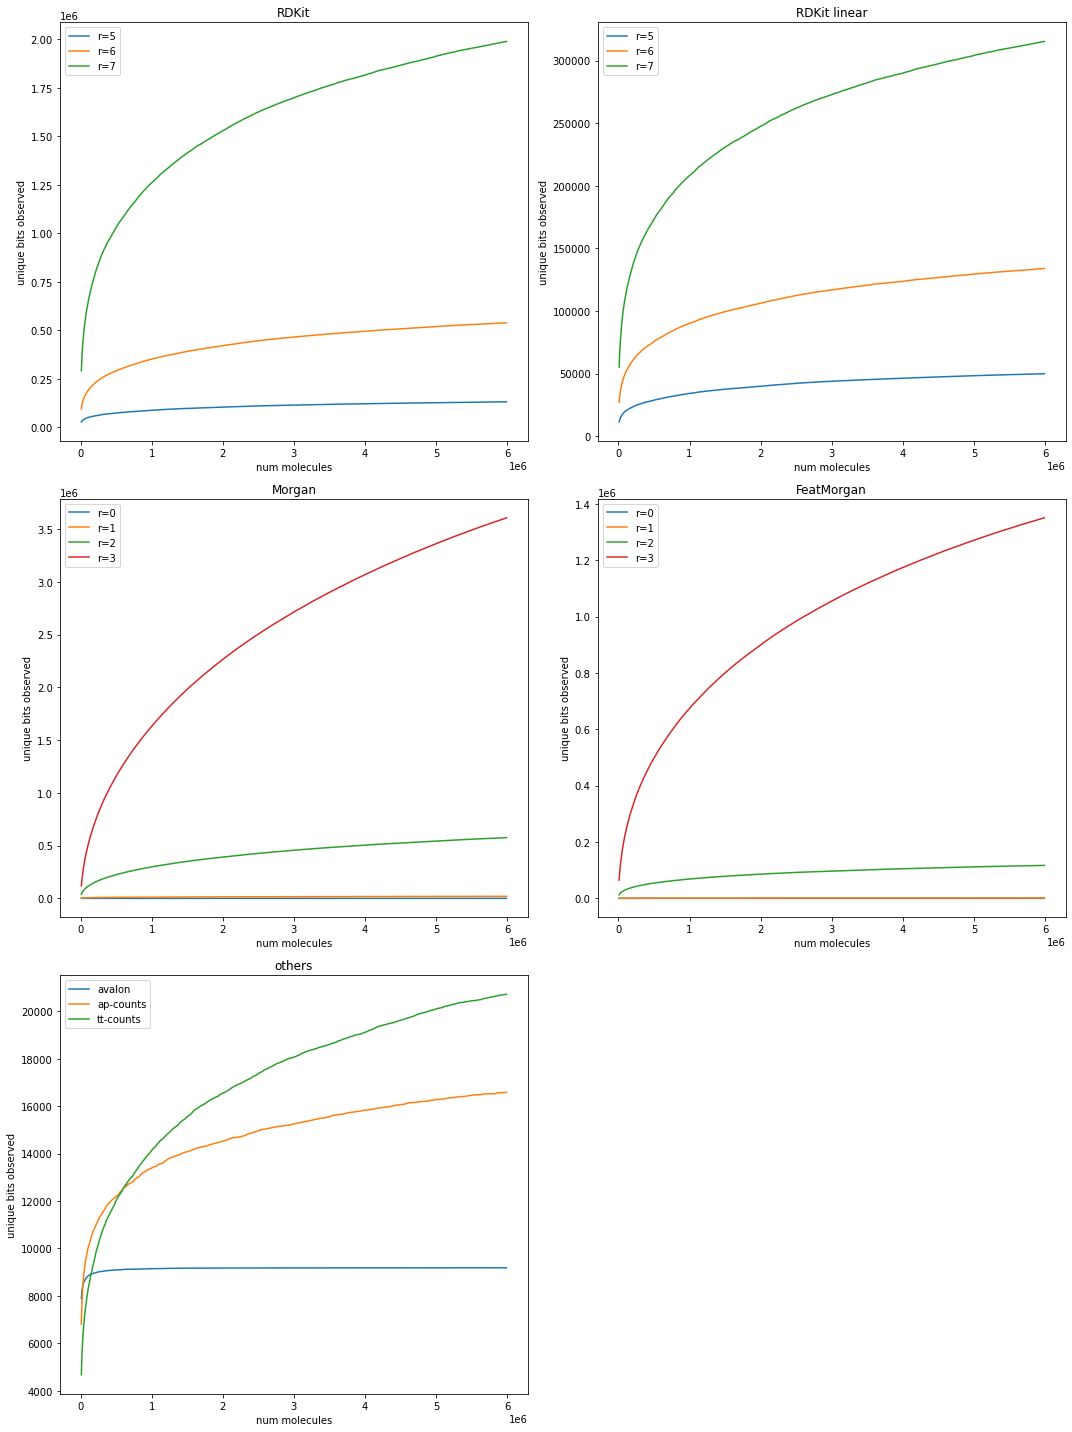

In [22]:
morgan_ks = [x for x in sorted(counts.keys()) if x[0] =='Morgan']
featmorgan_ks = [x for x in sorted(counts.keys()) if x[0] =='FeatMorgan']
rdkit_ks = [x for x in sorted(counts.keys()) if x[0] == 'RDKit']
rdkitlin_ks = [x for x in sorted(counts.keys()) if x[0] == 'RDKit-linear']

figure(figsize=(15,20))

pidx=1
subplot(3,2,pidx)
for n,r in rdkit_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("RDKit")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=legend()

pidx=2
subplot(3,2,pidx)
for n,r in rdkitlin_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("RDKit linear")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=legend()



pidx=3
subplot(3,2,pidx)
for n,r in morgan_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("Morgan")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=legend()

pidx=4
subplot(3,2,pidx)
for n,r in featmorgan_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("FeatMorgan")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=legend()

pidx+=1
subplot(3,2,pidx)
for k in counts.keys():
    if k[0].startswith('Morgan') or k[0].startswith('FeatMorgan') or k[0].startswith('RDKit'):
        continue
    pidx+=1
    cnts = counts[k]
    plot([x for x,y in cnts],[y for x,y in cnts],label=k[0])
_=title('others')
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=legend()
   
tight_layout();

Mabye better to plot those on a log scale?

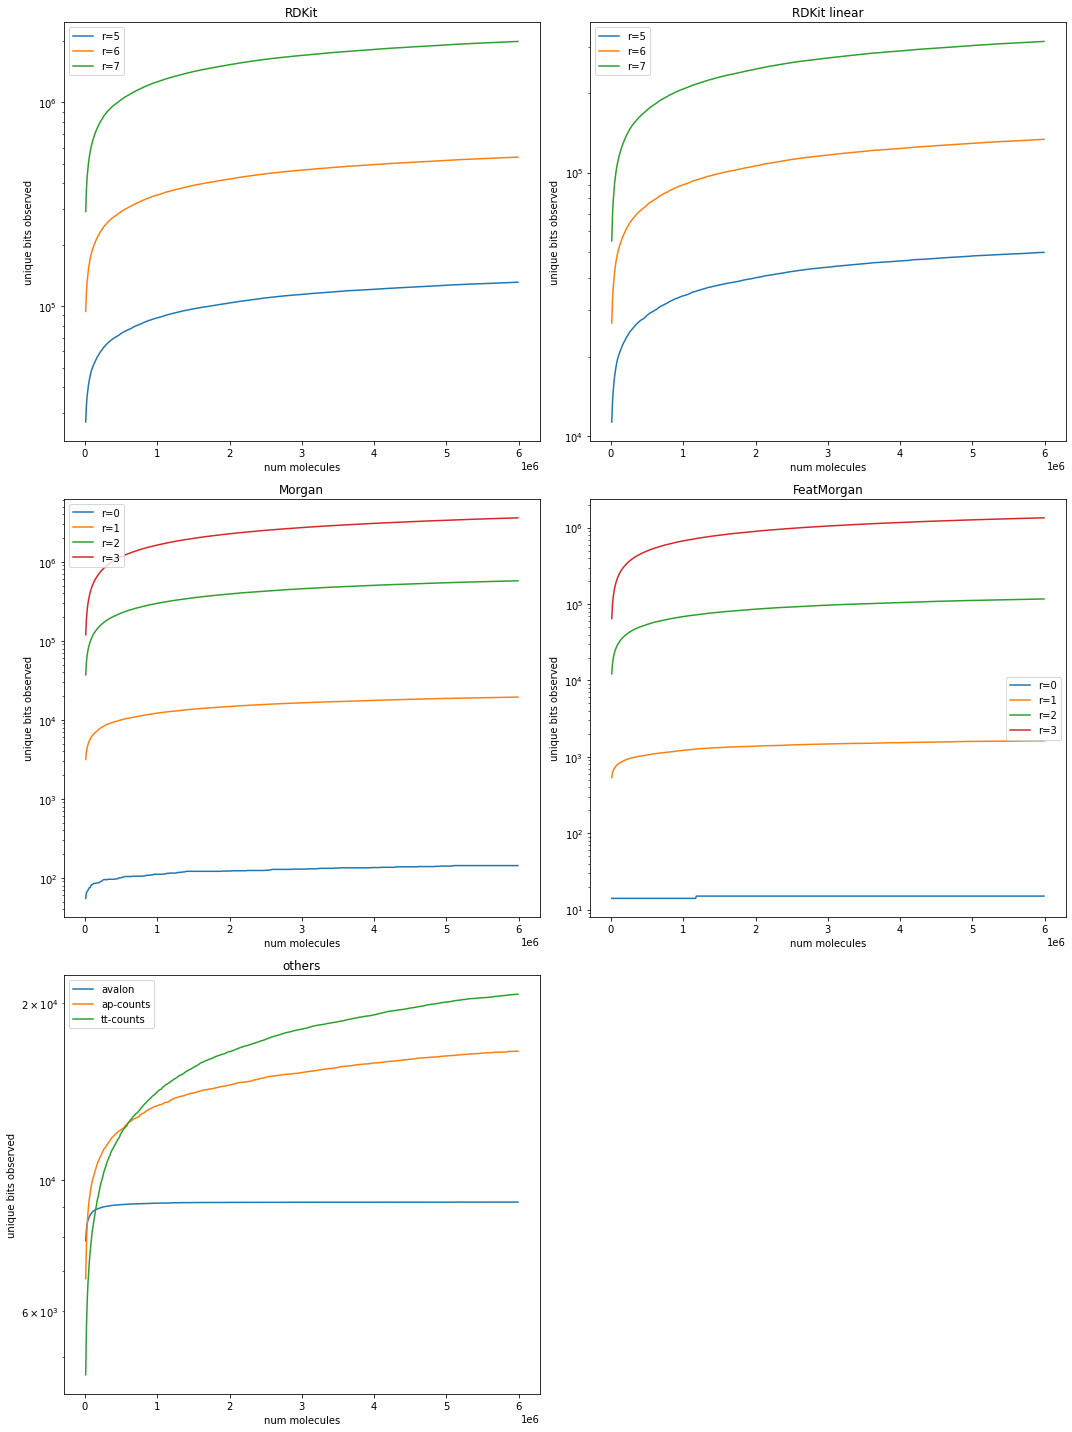

In [23]:
morgan_ks = [x for x in sorted(counts.keys()) if x[0] =='Morgan']
featmorgan_ks = [x for x in sorted(counts.keys()) if x[0] =='FeatMorgan']
rdkit_ks = [x for x in sorted(counts.keys()) if x[0] == 'RDKit']
rdkitlin_ks = [x for x in sorted(counts.keys()) if x[0] == 'RDKit-linear']

figure(figsize=(15,20))

pidx=1
subplot(3,2,pidx)
for n,r in rdkit_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("RDKit")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=yscale('log')
_=legend()

pidx=2
subplot(3,2,pidx)
for n,r in rdkitlin_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("RDKit linear")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=yscale('log')
_=legend()



pidx=3
subplot(3,2,pidx)
for n,r in morgan_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("Morgan")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=yscale('log')
_=legend()

pidx=4
subplot(3,2,pidx)
for n,r in featmorgan_ks:
    cnts = counts[(n,r)]
    
    plot([x for x,y in cnts],[y for x,y in cnts],label=
        f"r={r}")
_=title("FeatMorgan")
_=ylabel("unique bits observed")
_=xlabel("num molecules")
_=yscale('log')
_=legend()

pidx+=1
subplot(3,2,pidx)
for k in counts.keys():
    if k[0].startswith('Morgan') or k[0].startswith('FeatMorgan') or k[0].startswith('RDKit'):
        continue
    pidx+=1
    cnts = counts[k]
    plot([x for x,y in cnts],[y for x,y in cnts],label=k[0])
_=title('others')
_=ylabel("unique bits observed")
_=yscale('log')
_=xlabel("num molecules")
_=legend()

tight_layout();

*Notes:* 
- FeatMorgan with r=0 is super boring since there are only 15 types observed and 14 of them appear within the first 10K compounds (the last appears after around 1.2 million compounds). By way of comparison, there are 143 different Morgan0 types observed and the last of those doesn't show up until after about 5.1 million compounds.
- The Avalon fingerprint was 9192 bits long and it ends up setting all essentially of those bits (9185). It probably would have been better to run this with a longer fingerprint.

How many compounds do we need to look at in order to see particular fractions of the total number of bits there?

In [25]:
bins = (0.9,0.95,0.99)
print('|',' '*15,'|','# unique bits','|','# in last 100K','|',' | '.join(f'{x:7.2f}' for x in bins),'|')
print('|','-'*15,'|','-'*13,'|','-'*14,'|',' | '.join('-'*7 for x in bins),'|')
for k,cnts in sorted(counts.items()):
    label = ''.join(str(x) for x in k if x!=-1)
    maxv = cnts[-1][1]
    last100K = cnts[-1][1] - cnts[-11][1]
    if label=='FeatMorgan0':
        accum = ' | '.join([f'{"N/A":7s}']*3)
    else:
        accum = []
        for bin in bins:
            for idx in range(len(cnts),0,-1):
                if cnts[idx-1][1]<bin*maxv:
                    accum.append(cnts[idx-1][0])
                    break
        accum = ' | '.join(f'{x:7d}' for x in accum)
    print('|',f'{label:15s}','|',f'{maxv:13d}','|',f'{last100K:14d}','|',accum,'|')

|                 | # unique bits | # in last 100K |    0.90 |    0.95 |    0.99 |
| --------------- | ------------- | -------------- | ------- | ------- | ------- |
| FeatMorgan0     |            15 |              0 | N/A     | N/A     | N/A     |
| FeatMorgan1     |          1621 |              2 | 2760000 | 4080000 | 5460000 |
| FeatMorgan2     |        116975 |            464 | 4000000 | 4870000 | 5750000 |
| FeatMorgan3     |       1350464 |           7478 | 4400000 | 5130000 | 5810000 |
| Morgan0         |           143 |              0 | 2850000 | 4080000 | 5080000 |
| Morgan1         |         19428 |             67 | 3870000 | 4750000 | 5720000 |
| Morgan2         |        575817 |           2941 | 4320000 | 5080000 | 5790000 |
| Morgan3         |       3606676 |          22970 | 4580000 | 5240000 | 5830000 |
| RDKit5          |        131029 |            347 | 3490000 | 4600000 | 5690000 |
| RDKit6          |        538500 |           1627 | 3600000 | 4680000 | 5700000 |
| RD

What fraction of the overall number of bits appear in the last 100K compounds?

In [26]:
bins = (0.9,0.95,0.99)
for k,cnts in sorted(counts.items()):
    label = ''.join(str(x) for x in k if x!=-1)
    maxv = cnts[-1][1]
    last100K = cnts[-1][1] - cnts[-11][1]
    print(label,last100K/maxv)


FeatMorgan0 0.0
FeatMorgan1 0.0012338062924120913
FeatMorgan2 0.003966659542637315
FeatMorgan3 0.005537356049476328
Morgan0 0.0
Morgan1 0.0034486308420835906
Morgan2 0.005107525481185863
Morgan3 0.006368745071639371
RDKit5 0.0026482687038747147
RDKit6 0.003021355617455896
RDKit7 0.0034659022954253308
RDKit-linear5 0.0027280751023028163
RDKit-linear6 0.003002150794599116
RDKit-linear7 0.00327314593092774
ap-counts 0.0010853180584865843
avalon 0.0
tt-counts 0.002364522511219418
